In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from scipy.stats import norm
import time
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import kagglehub
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from time import time
import os

In [51]:
working_dir = './titanic/'

In [52]:
trainpath = working_dir + 'train.csv'
df = pd.read_csv(os.path.join(trainpath))

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [54]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [55]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


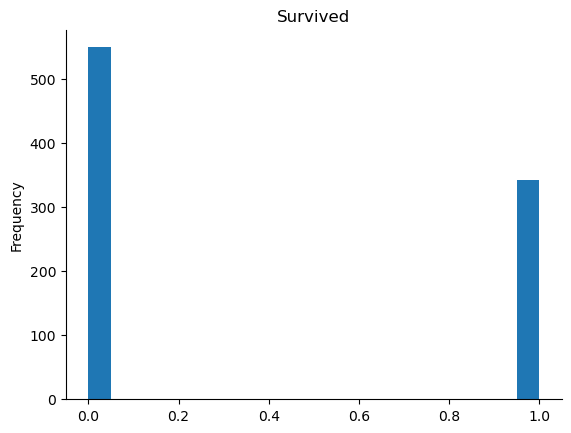

In [56]:
df['Survived'].plot(kind='hist', bins=20, title='Survived')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [57]:
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# заполнение пропусков
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# кодирование категориальных переменных
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

In [58]:
X = df.drop('Survived', axis=1).values
y = df['Survived'].values
feature_names = df.drop('Survived', axis=1).columns.tolist()

In [59]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [62]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=10).fit_transform(X=X)
pca = PCA(n_components=2).fit_transform(X)

Text(0.5, 1.0, 'PCA')

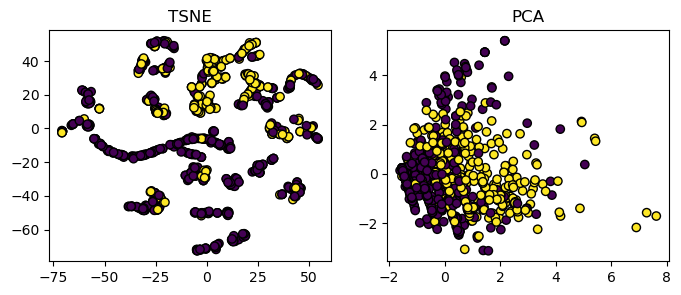

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

axes[0].scatter(tsne[:, 0], tsne[:, 1], c=y, edgecolor='k')
axes[0].set_title("TSNE")

axes[1].scatter(pca[:, 0], pca[:, 1], c=y, edgecolor='k')
axes[1].set_title("PCA")

In [64]:
def id3(X, y, feature_names, criterion="entropy", max_depth=None, current_depth=0):
    # Базовые случаи
    if len(np.unique(y)) == 1 or len(feature_names) == 0 or (max_depth is not None and current_depth >= max_depth):
        return Counter(y).most_common(1)[0][0]

    gains = CRITERIA[criterion](X, y)
    best_feature_idx = np.argmax(gains)
    best_feature = feature_names[best_feature_idx]

    tree = {best_feature: {}}

    for value in np.unique(X[:, best_feature_idx]):
        subset_X = X[X[:, best_feature_idx] == value]
        subset_y = y[X[:, best_feature_idx] == value]
        
        subtree = id3(
            np.delete(subset_X, best_feature_idx, axis=1),
            subset_y,
            feature_names[:best_feature_idx] + feature_names[best_feature_idx + 1:],
            criterion=criterion,
            max_depth=max_depth,
            current_depth=current_depth + 1
        )
        tree[best_feature][value] = subtree

    return tree

def prune_tree(tree, min_samples=5):
    if not isinstance(tree, dict):
        return tree

    pruned_tree = {}
    for key in tree:
        subtree = tree[key]
        if isinstance(subtree, dict):
            subtree = {subkey: prune_tree(subval, min_samples) for subkey, subval in subtree.items()}

            # Если все значения поддерева ведут к одному результату
            leaf_values = list(subtree.values())
            if all(isinstance(leaf, dict) == False and leaf == leaf_values[0] for leaf in leaf_values):
                return leaf_values[0]
        pruned_tree[key] = subtree

    return pruned_tree

def entropy(y):
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    return -sum(p * np.log2(p) for p in probabilities if p > 0)

def multiclass_entropy_criterion(X_column, y):
    counts = Counter(y)
    total_count = len(y)
    weighted_entropy = 0

    for c in counts:
        Pc = counts[c] / total_count
        p = len(X_column[X_column == c]) / total_count
        if p > 0:
            weighted_entropy += Pc * (-p * np.log2(p))

    return weighted_entropy

def donskoy_criterion(X, y):
    n = len(y)
    count = 0
    for i in range(n):
        for j in range(i + 1, n):
            if (y[i] != y[j]) and (X[i] != X[j]):
                count += 1
    return count

CRITERIA = {
    "entropy": lambda X, y: [multiclass_entropy_criterion(X[:, i], y) for i in range(X.shape[1])],
    "donskoy": lambda X, y: [donskoy_criterion(X[:, i], y) for i in range(X.shape[1])]
}



In [65]:
def predict(tree, X_sample, feature_names):
    if not isinstance(tree, dict):
        return tree
    root_node = next(iter(tree))
    feature_idx = feature_names.index(root_node)
    subtree = tree[root_node].get(X_sample[feature_idx], Counter(y_train).most_common(1)[0][0])
    return predict(subtree, X_sample, feature_names)


In [66]:
if __name__ == "__main__":
    # Обучение дерева с критерием энтропии
    start_time = time()
    tree_entropy = id3(X_train, y_train, feature_names, criterion="entropy")
    entropy_time = time() - start_time
    # print("Построенное дерево (энтропия):", tree_entropy)

    # Обучение дерева с критерием Донского
    start_time = time()
    tree_donskoy = id3(X_train, y_train, feature_names, criterion="donskoy")
    donskoy_time = time() - start_time
    # print("Построенное дерево (Донской):", tree_donskoy)

    # редукция дерева
    pruned_tree_entropy = prune_tree(tree_entropy)
    pruned_tree_donskoy = prune_tree(tree_donskoy)
    
    y_pred_entropy = [predict(pruned_tree_entropy, x, feature_names) for x in X_test]
    entropy_accuracy = accuracy_score(y_test, y_pred_entropy)
    print("Точность (энтропия):", entropy_accuracy)

    y_pred_donskoy = [predict(pruned_tree_donskoy, x, feature_names) for x in X_test]
    donskoy_accuracy = accuracy_score(y_test, y_pred_donskoy)
    print("Точность (Донской):", donskoy_accuracy)

    # Сравнение времени работы
    print("Время работы (энтропия):", entropy_time)
    print("Время работы (Донской):", donskoy_time)

    # Сравнение с библиотечной реализацией дерева
    start_time = time()
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)
    lib_tree_time = time() - start_time

    lib_y_pred = clf.predict(X_test)
    lib_accuracy = accuracy_score(y_test, lib_y_pred)
    lib_mse = mean_squared_error(y_test, lib_y_pred)

    print("Точность (библиотечное дерево):", lib_accuracy)
    print("Среднеквадратичная ошибка (библиотечное дерево):", lib_mse)
    print("Время работы (библиотечное дерево):", lib_tree_time)


Точность (энтропия): 0.7877094972067039
Точность (Донской): 0.7039106145251397
Время работы (энтропия): 0.05005931854248047
Время работы (Донской): 1.8540427684783936
Точность (библиотечное дерево): 0.7821229050279329
Среднеквадратичная ошибка (библиотечное дерево): 0.21787709497206703
Время работы (библиотечное дерево): 0.0049800872802734375


In [67]:
# --- 6. Дополнительные метрики ---
print("Custom Classification Report entropy:")
print(classification_report(y_test, y_pred_entropy))

print("\nCustom Classification Report donskoy:")
print(classification_report(y_test, y_pred_donskoy))

print("\nБиблиотечная Classification Report:")
print(classification_report(y_test, lib_y_pred))

Custom Classification Report entropy:
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       105
           1       0.88      0.57      0.69        74

    accuracy                           0.79       179
   macro avg       0.82      0.76      0.76       179
weighted avg       0.81      0.79      0.78       179


Custom Classification Report donskoy:
              precision    recall  f1-score   support

           0       0.69      0.91      0.78       105
           1       0.77      0.41      0.53        74

    accuracy                           0.70       179
   macro avg       0.73      0.66      0.66       179
weighted avg       0.72      0.70      0.68       179


Библиотечная Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       105
           1       0.72      0.78      0.75        74

    accuracy                           0.78       179
   macro avg  

In [68]:
# --- 7. Матрица ошибок ---
print("Custom Confusion Matrix entropy:")
print(confusion_matrix(y_test, y_pred_entropy))

print("\nCustom Confusion Matrix donskoy:")
print(confusion_matrix(y_test, y_pred_donskoy))

print("\nБиблиотечная Confusion Matrix:")
print(confusion_matrix(y_test, lib_y_pred))

Custom Confusion Matrix entropy:
[[99  6]
 [32 42]]

Custom Confusion Matrix donskoy:
[[96  9]
 [44 30]]

Библиотечная Confusion Matrix:
[[82 23]
 [16 58]]


## Задача регрессии

In [127]:
df = pd.read_csv('data.csv')

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Socioeconomic Score  1388 non-null   float64
 1   Study Hours          1388 non-null   float64
 2   Sleep Hours          1388 non-null   float64
 3   Attendance (%)       1388 non-null   float64
 4   Grades               1388 non-null   float64
dtypes: float64(5)
memory usage: 54.3 KB


In [137]:
y = df['Grades'].values
X = df.drop(['Grades'], axis = 1)
feature_names = df.drop('Grades', axis=1).columns.tolist()

In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [139]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y, test_size=0.2, random_state=42)

In [144]:
class RegressionTree:
    def __init__(self, min_samples_split=2, max_depth=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree = None

    def mse(self, y):
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def fit(self, X, y):
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        if len(y) < self.min_samples_split or (self.max_depth is not None and depth >= self.max_depth):
            return np.mean(y)

        best_feature, best_split = None, None
        best_mse = float("inf")
        current_mse = self.mse(y)

        for feature in X.columns:
            thresholds = np.unique(X[feature])
            for threshold in thresholds:
                left_mask = X[feature] <= threshold
                right_mask = X[feature] > threshold

                if sum(left_mask) == 0 or sum(right_mask) == 0:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                mse_split = (len(y_left) / len(y)) * self.mse(y_left) + (len(y_right) / len(y)) * self.mse(y_right)

                if mse_split < best_mse:
                    best_mse = mse_split
                    best_feature = feature
                    best_split = threshold

        if best_feature is None or best_mse >= current_mse:
            return np.mean(y)

        left_mask = X[best_feature] <= best_split
        right_mask = X[best_feature] > best_split

        left_subtree = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return {
            "feature": best_feature,
            "threshold": best_split,
            "left": left_subtree,
            "right": right_subtree,
        }

    def predict_sample(self, x, tree):
        if not isinstance(tree, dict):
            return tree

        feature, threshold = tree["feature"], tree["threshold"]
        if x[feature] <= threshold:
            return self.predict_sample(x, tree["left"])
        else:
            return self.predict_sample(x, tree["right"])

    def predict(self, X):
        return X.apply(lambda x: self.predict_sample(x, self.tree), axis=1)


X_train_reg = pd.DataFrame(X_train_reg, columns=feature_names)
X_test_reg = pd.DataFrame(X_test_reg, columns=feature_names)

# Повторное обучение дерева регрессии
reg_tree = RegressionTree(min_samples_split=5, max_depth=10)
reg_tree.fit(X_train_reg, y_train_reg)

# Предсказание и вычисление MSE
y_pred_reg = reg_tree.predict(X_test_reg)
regression_mse = mean_squared_error(y_test_reg, y_pred_reg)

regression_mse

3.257678276383865